In [ ]:

import pandas as pd
import numpy as np
import os
import joblib
from keras import utils
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras

In [ ]:
# prompt: mount my drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Loaded Promoter,Non-promoter Sequences for Traininig

In [ ]:
import pandas as pd

# Load non-promoter sequence

df = pd.read_csv('/content/drive/MyDrive/NonPromoterSequence.txt', sep = '>', )
df.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
df.reset_index(inplace = True)
df.drop(['EP 1 (+) mt:CoI_1; range -400 to -100.', 'index'], axis = 1, inplace=True) #data cleaning after error found
df.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
df['label'] = 0
display(df)
display(df.shape)


,sequence,label
0,TAATTACATTATTTTTTTATTTACGAATTTGTTATTCCGCTTTTAT...,0
1,ATTTTTACAAGAACAAGACATTTAACTTTAACTTTATCTTTAGCTT...,0
2,AGAGATAGGTGGGTCTGTAACACTCGAATCAAAAACAATATTAAGA...,0
3,TATGTATATAGAGATAGGCGTTGCCAATAACTTTTGCGTTTTTTGC...,0
4,AGAAATAATAGCTAGAGCAAAAAACAGCTTAGAACGGCTGATGCTC...,0
...,...,...
11295,TGGTAAAAAATTGTACACCTAACTAGTGCCTTCATGTATACCACCA...,0
11296,AGTGCAACTGGAGCCGTGCCGTGACCCACAGAGATCGCCCACTCGA...,0
11297,GCATGGATTTCATATTATCTTAATCGACTTGCTTTTATAAAATAGG...,0
11298,GTGACCAGGTTTTGCTCTAATGCGAAGTACGGATTGGGTAGAGATA...,0


(11300, 2)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/PromoterSequence.txt', sep = '>', )
df2.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
df2.reset_index(inplace = True)
df2.drop(['EP 1 (+) mt:CoI_1; range -100 to 200.', 'index'], axis = 1, inplace=True)
df2.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
df2['label'] = 1

display(df2)
display(df2.shape)

,sequence,label
0,TTAATTTGTCCTTATTTGATTAAGAAGAATAAATCTTATATATAGA...,1
1,ATAGCTCAAATTGCTTTATTAGTATTAGAATCAGCTGTAGCTATAA...,1
2,AAGCTTCCCTTTAATGTGCTCCTTGTGAATACAGCATTACAATGCC...,1
3,TATGTAGAATCTGTACAAGTATCTGTGTTTGGACAATGGCATGTGT...,1
4,ACATATTACTGCATACAGGTCTCAAATTATAAAATGACACTCGTGG...,1
...,...,...
11295,CGACAAAGTTTGATCCATGTGCATTCTTGGCGCCTTATCGATAGCT...,1
11296,CATATCTACATCTCGCTTGCTCCTTCCCTTTCGCTGCGTGTGTGTG...,1
11297,ATACCGCGGAAGCGCAAAAGTACCAGAATTTCCCTGGTATCGCGCT...,1
11298,ATTATTCCGAATTCTTTTATCAGATTTAAATATGGGAAACACTTTA...,1


(11300, 2)

# Some Preprocessing

In [ ]:
df = pd.concat([df, df2], axis = 0 )
df.shape

(22600, 2)

In [ ]:
for seq in df['sequence']:
    if 'N' in seq:
        display(df.loc[df['sequence'] == seq])

,sequence,label
1822,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGAATTC...,0


In [ ]:
df.drop([1822], inplace = True)

In [ ]:
for seq in df['sequence']:
    if 'N' in seq:
        display(df.loc[df['sequence'] == seq])

In [ ]:
sequence = list(df.loc[:, 'sequence'])
encoded_list = []

In [ ]:
import numpy as np
def encode_seq(s):
    Encode = {'A':[1,0,0,0],'T':[0,1,0,0],'C':[0,0,1,0],'G':[0,0,0,1]}
    return [Encode[x] for x in s]

for i in sequence:
    x = encode_seq(i)
    encoded_list.append(x)

X = np.array(encoded_list)
X.shape

(22598, 301, 4)

In [ ]:
y = df['label']
y.shape

(22598,)

# Training GRU Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [ ]:
params = {
    'first_node': [128, 64],
    'second_node': [32, 64],
    'alpha': [0.001, 0.01],
    'first_filter': [9, 16, 32],
    'dropout': [0.1, 0.2, 0.5]
}

In [ ]:
gru_model = Sequential()
gru_model.add(Conv1D(27, 4, activation='relu', input_shape=(301, 4)))
gru_model.add(MaxPooling1D(3))
gru_model.add(Dropout(0.2))

gru_model.add(Conv1D(14, 2, activation='relu', padding='same'))
gru_model.add(Bidirectional(GRU(128, activation='relu')))
gru_model.add(Dropout(0.2))

gru_model.add(Dense(128, activation='relu'))
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

history = gru_model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=50,
                        batch_size=128,
                        callbacks=[early_stop])


Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.6077 - loss: 0.8306 - val_accuracy: 0.7388 - val_loss: 0.5960
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7300 - loss: 0.5953 - val_accuracy: 0.7281 - val_loss: 0.5618
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7484 - loss: 0.5316 - val_accuracy: 0.7545 - val_loss: 0.5195
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7501 - loss: 0.5208 - val_accuracy: 0.7529 - val_loss: 0.5104
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7524 - loss: 0.5097 - val_accuracy: 0.7595 - val_loss: 0.5017
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7618 - loss: 0.5058 - val_accuracy: 0.7480 - val_loss: 0.5151
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7636 - loss: 0.5015 - val_accuracy: 0.7612 - val_loss: 0.4945
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7626 - loss: 0.4990 - val_acc

In [ ]:
gru_model.save("/content/drive/MyDrive/promoter_model.h5")


# Testing

In [ ]:
sequence = list(df.loc[:, 'sequence'])
encoded_list = []

In [ ]:
def encode_seq(s):
    Encode = {'A':[1,0,0,0],'T':[0,1,0,0],'C':[0,0,1,0],'G':[0,0,0,1]}
    return [Encode[x] for x in s]

for i in sequence:
    x = encode_seq(i)
    encoded_list.append(x)

X_test_test = np.array(encoded_list)
X_test_test.shape

(22598, 301, 4)

In [ ]:
# Get prediction probabilities (shape: [num_samples, 1])
y_pred_prob = gru_model.predict(X_test_test)

# Convert to binary class predictions using threshold 0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)


707/707 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


In [ ]:
# Get 10 promoters and 10 non-promoters from your full dataset
df_promoters = df[df['label'] == 1].sample(10, random_state=42)
df_nonpromoters = df[df['label'] == 0].sample(10, random_state=42)

# Combine and shuffle them
df_test_mix = pd.concat([df_promoters, df_nonpromoters]).sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
def encode_seq(s):
    Encode = {'A':[1,0,0,0],'T':[0,1,0,0],'C':[0,0,1,0],'G':[0,0,0,1]}
    return [Encode[x] for x in s]

encoded_mix = [encode_seq(seq) for seq in df_test_mix['sequence']]
X_test_mix = np.array(encoded_mix)
y_test_mix = df_test_mix['label'].values


In [ ]:
y_pred_prob = gru_model.predict(X_test_mix)
y_pred_class = (y_pred_prob > 0.5).astype(int)

for i in range(len(y_test_mix)):
    print(f"True: {y_test_mix[i]}, Predicted: {y_pred_class[i][0]}, Prob: {y_pred_prob[i][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
True: 1, Predicted: 1, Prob: 0.9481
True: 0, Predicted: 0, Prob: 0.0721
True: 0, Predicted: 0, Prob: 0.1275
True: 1, Predicted: 1, Prob: 0.8439
True: 1, Predicted: 1, Prob: 0.9887
True: 1, Predicted: 0, Prob: 0.0618
True: 0, Predicted: 0, Prob: 0.2026
True: 1, Predicted: 1, Prob: 0.8316
True: 0, Predicted: 0, Prob: 0.0820
True: 0, Predicted: 0, Prob: 0.0951
True: 0, Predicted: 0, Prob: 0.0280
True: 1, Predicted: 1, Prob: 0.7587
True: 1, Predicted: 1, Prob: 0.8315
True: 0, Predicted: 0, Prob: 0.0243
True: 1, Predicted: 1, Prob: 0.7595
True: 0, Predicted: 0, Prob: 0.0620
True: 1, Predicted: 1, Prob: 0.9910
True: 0, Predicted: 0, Prob: 0.0067
True: 0, Predicted: 0, Prob: 0.2645
True: 1, Predicted: 1, Prob: 0.9011


# Loading The Model

In [ ]:
from tensorflow.keras.models import load_model
model= load_model("/content/drive/MyDrive/promoter_model.h5")

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 298, 27)        │           459 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 99, 14)         │           770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       110,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,192 (617.94 KB)

 Trainable params: 158,190 (617.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


NameError: name 'X_test' is not defined

# Loading Massive Genes Datasets

In [ ]:
import pandas as pd

df_oncogenes = pd.read_csv("/content/drive/MyDrive/Cosmic_CancerGeneCensus_v101_GRCh38.tsv", sep='\t')
df_oncogenes.head()


,GENE_SYMBOL,NAME,COSMIC_GENE_ID,CHROMOSOME,GENOME_START,GENOME_STOP,CHR_BAND,SOMATIC,GERMLINE,TUMOUR_TYPES_SOMATIC,...,CANCER_SYNDROME,TISSUE_TYPE,MOLECULAR_GENETICS,ROLE_IN_CANCER,MUTATION_TYPES,TRANSLOCATION_PARTNER,OTHER_GERMLINE_MUT,OTHER_SYNDROME,TIER,SYNONYMS
0,A1CF,APOBEC1 complementation factor,COSG68236,10,50799409.0,50885675.0,10q11.23,y,n,melanoma,...,NaN,E,NaN,oncogene,Mis,NaN,n,NaN,2,"A1CF,ENSG00000148584.14,29974,ACF,ACF64,ACF65,..."
1,ABI1,abl interactor 1,COSG100962,10,26746593.0,26861087.0,10p12.1,y,n,AML,...,NaN,L,Dom,"TSG, fusion",T,KMT2A,n,NaN,1,"ABI1,ENSG00000136754.17,Q8IZP0,10006,ABI-1,E3B1"
2,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",COSG106650,9,130713946.0,130887675.0,9q34.12,y,n,"CML, ALL, T-ALL",...,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",n,NaN,1,"ABL1,ENSG00000097007.17,P00519,25,JTK7,c-ABL,p150"
3,ABL2,"ABL proto-oncogene 2, non-receptor tyrosine ki...",COSG93778,1,179099327.0,179229684.0,1q25.2,y,n,AML,...,NaN,L,Dom,"oncogene, fusion",T,ETV6,n,NaN,1,"ABL2,ENSG00000143322.19,P42684,27,ARG"
4,ACKR3,atypical chemokine receptor 3,COSG97311,2,236567787.0,236582358.0,2q37.3,y,n,lipoma,...,NaN,M,Dom,"oncogene, fusion",T,HMGA2,n,NaN,1,"ACKR3,ENSG00000144476.5,P25106,57007,GPR159,RDC1"


# Filtering Oncogenes for Our Scope

In [ ]:
# Filter oncogenes only
df_onco_filtered = df_oncogenes[df_oncogenes['ROLE_IN_CANCER'].str.contains('oncogene', na=False)]

# Drop entries without coordinates
df_onco_filtered = df_onco_filtered.dropna(subset=['GENOME_START', 'GENOME_STOP'])

# Format and rename for clarity
df_onco_filtered = df_onco_filtered[['GENE_SYMBOL', 'CHROMOSOME', 'GENOME_START', 'GENOME_STOP']]
df_onco_filtered.columns = ['gene', 'chr', 'start', 'end']

# Convert positions to integers
df_onco_filtered['start'] = df_onco_filtered['start'].astype(int)
df_onco_filtered['end'] = df_onco_filtered['end'].astype(int)

df_onco_filtered = df_onco_filtered.reset_index(drop=True)
df_onco_filtered.head()


,gene,chr,start,end
0,A1CF,10,50799409,50885675
1,ABL1,9,130713946,130887675
2,ABL2,1,179099327,179229684
3,ACKR3,2,236567787,236582358
4,ACVR1,2,157736444,157875862


# Simulate Mapping and Check Oncogene

In [ ]:
def predict_promoter(sequence, model):
    encoded = encode_sequence(sequence)
    encoded = encoded.reshape(1, encoded.shape[0], 4)  # shape: (1, 301, 4)
    prob = model.predict(encoded)[0][0]
    return prob, prob > 0.5


In [ ]:
def encode_sequence(s):
    encode_map = {'A':[1,0,0,0], 'T':[0,1,0,0], 'C':[0,0,1,0], 'G':[0,0,0,1]}
    return np.array([encode_map[x] for x in s])


In [ ]:
import random
def simulate_mapping_and_check_oncogene(promoter_seq, model, oncogene_df):
    prob, is_promoter = predict_promoter(promoter_seq, model)
    if not is_promoter:
        return {"result": "Not a promoter", "probability": prob}

    # Simulate mapping (pick a random oncogene and assign the promoter just upstream of it)
    random_gene = oncogene_df.sample(1).iloc[0]
    gene_start = random_gene['start']
    promoter_end = gene_start - random.randint(1, 1000)
    promoter_start = promoter_end - len(promoter_seq)

    # Check if it's upstream
    if gene_start - 1000 <= promoter_end <= gene_start:
        return {
            "result": "Promoter upstream of oncogene",
            "probability": prob,
            "gene": random_gene['gene'],
            "chr": random_gene['chr'],
            "promoter_start": promoter_start,
            "promoter_end": promoter_end,
            "gene_start": gene_start
        }
    else:
        return {"result": "Promoter, but not upstream of oncogene", "probability": prob}


In [ ]:
test_sequence = "AAGGGGCCTTATACATAGTTAACTTATGAATTTATTTACTAACGTTGTGTTGTCATCACATCAGCTCATCACTAGCTCACTCGCTCATCTCTAATCGAACAGCTGATTGCTGCGAACCGGAACAAATGGAAATTGTATCGTGAGGCAAGTGGAGTTTCCCCTTTACTTTTGGCAAATAATAAATAAACAAAGGAACAAGCCTAAACATTTTCAATTAAACCATATACAGAACTAACGCACACATGTGACGGAGGCAATACACAAACACGGCACCTTTGAATCTCGCCTTAAAATTGGCGAA"  # Insert any 301bp DNA sequence
print(len(test_sequence))
result = simulate_mapping_and_check_oncogene(test_sequence, model, df_onco_filtered)
print(result)


301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
{'result': 'Promoter upstream of oncogene', 'probability': np.float32(0.62577134), 'gene': 'RECQL4', 'chr': '8', 'promoter_start': np.int64(144510510), 'promoter_end': np.int64(144510811), 'gene_start': np.int64(144511288)}


# Real Upstream Promoters Scanning

In [ ]:
!gunzip /content/drive/MyDrive/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz


In [ ]:
!pip install biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.5 MB/s eta 0:00:00


We Check 1000bp upstream of each gene start for Promoters

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import numpy as np

def encode_sequence(seq):
    encode_map = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'C': [0, 0, 1, 0], 'G': [0, 0, 0, 1]}
    return np.array([encode_map.get(base, [0, 0, 0, 0]) for base in seq.upper()])

def reverse_complement(seq):
    return str(Seq(seq).reverse_complement())

def scan_upstream_promoters(fasta_path, model, oncogene_df, window_size=301, step=50):
    # Load the genome into memory for fast access
    genome = {
        record.id.replace("chr", "").replace("CHR", ""): record.seq.upper()
        for record in SeqIO.parse(fasta_path, "fasta")
    }

    results = []

    for _, row in oncogene_df.iterrows():
        chrom = str(row['chr']).replace("chr", "").replace("CHR", "")
        start = int(row['start'])
        strand = row.get('strand', '+') if 'strand' in row else '+'
        gene = row['gene']

        if chrom not in genome:
            continue

        seq = genome[chrom]

        # Get 1000bp upstream of gene start
        if strand == '+':
            promoter_region = seq[max(0, start - 1000):start]
            promoter_start_base = start - 1000
        else:
            promoter_region = reverse_complement(seq[start:start + 1000])
            promoter_start_base = start

        # Slide across the promoter region
        for i in range(0, len(promoter_region) - window_size, step):
            sub_seq = promoter_region[i:i + window_size]
            if set(sub_seq) <= {'A', 'T', 'C', 'G'}:
                encoded = encode_sequence(sub_seq).reshape(1, window_size, 4)
                prob = model.predict(encoded, verbose=0)[0][0]
                if prob > 0.5:
                    result = {
                        "gene": gene,
                        "chr": chrom,
                        "strand": strand,
                        "promoter_start": promoter_start_base + i,
                        "promoter_end": promoter_start_base + i + window_size,
                        "probability": float(prob)
                    }
                    results.append(result)

    return results


In [ ]:
fasta_path = "/content/drive/MyDrive/Homo_sapiens.GRCh38.dna.primary_assembly.fa"
results = scan_upstream_promoters(fasta_path, model, df_onco_filtered)


In [ ]:
results

[{'gene': 'A1CF',
  'chr': '10',
  'strand': '+',
  'promoter_start': 50798809,
  'promoter_end': 50799110,
  'probability': 0.6237567663192749},
 {'gene': 'A1CF',
  'chr': '10',
  'strand': '+',
  'promoter_start': 50798859,
  'promoter_end': 50799160,
  'probability': 0.7450208067893982},
 {'gene': 'ABL2',
  'chr': '1',
  'strand': '+',
  'promoter_start': 179098577,
  'promoter_end': 179098878,
  'probability': 0.8191819787025452},
 {'gene': 'ABL2',
  'chr': '1',
  'strand': '+',
  'promoter_start': 179098677,
  'promoter_end': 179098978,
  'probability': 0.6231791973114014},
 {'gene': 'ACKR3',
  'chr': '2',
  'strand': '+',
  'promoter_start': 236567437,
  'promoter_end': 236567738,
  'probability': 0.7827600836753845},
 {'gene': 'ACVR1',
  'chr': '2',
  'strand': '+',
  'promoter_start': 157735444,
  'promoter_end': 157735745,
  'probability': 0.501349925994873},
 {'gene': 'AFDN',
  'chr': '6',
  'strand': '+',
  'promoter_start': 167826372,
  'promoter_end': 167826673,
  'probabi

In [ ]:
# Assuming your output list is named `results`
unique_genes_hit = set([entry['gene'] for entry in results])
print(f"Number of unique oncogenes with predicted promoters: {len(unique_genes_hit)}")

# Optionally, list them:
print("\nGenes hit:")
for gene in sorted(unique_genes_hit):
    print(gene)


Number of unique oncogenes with predicted promoters: 235

Genes hit:
A1CF
ABL2
ACKR3
ACVR1
AFDN
AFF3
AFF4
AKT2
AR
ARAF
ARNT
ATF1
ATP1A1
BCL11A
BCL11B
BCL2
BCL2L12
BCL6
BCL9L
BIRC3
BIRC6
BMPR1A
BRAF
BRD3
BRD4
BTK
CARD11
CBL
CCND1
CCND2
CCND3
CCR4
CD74
CD79A
CDH17
CDK4
CDK6
CDKN1A
CHST11
CIC
CREB1
CREB3L2
CREBBP
CRLF2
CSF3R
CTNND2
CXCR4
CYSLTR2
DAXX
DDB2
DDIT3
DDR2
DDX5
DDX6
DGCR8
EGFR
ELF4
ERBB2
ERBB4
ERG
ETV4
ETV5
EZH2
FCGR2B
FCRL4
FES
FGFR2
FGFR4
FLI1
FLT3
FLT4
FOXA1
FOXL2
FOXO1
FOXO3
FOXO4
FOXR1
FUBP1
GATA1
GATA2
GNA11
GNAQ
GNAS
GPC3
GRM3
H3F3A
H3F3B
HEY1
HIF1A
HIST1H3B
HLF
HMGA1
HMGA2
HNRNPA2B1
HOXA13
HOXA9
HOXC13
HOXD11
HOXD13
IDH2
IKBKB
IKZF3
IL6ST
IL7R
IRF4
JAK1
JAK2
JAK3
JUN
KAT6A
KDM5A
KIT
KLF4
KMT2A
KMT2D
KNSTRN
LEF1
LMO2
LPP
LYN
MACC1
MAF
MALAT1
MALT1
MAML2
MAP2K1
MAP2K4
MAP3K1
MAP3K13
MDM2
MDM4
MECOM
MITF
MLLT10
MN1
MPL
MSI2
MTCP1
MUC4
MYB
MYC
MYCL
MYCN
MYOD1
NCOA2
NFE2L2
NFKB2
NKX2-1
NOTCH2
NPM1
NR4A3
NSD2
NT5C2
NTRK1
NTRK2
NUTM1
OLIG2
PABPC1
PAX3
PAX5
PBX1
PDCD1LG2
PDGFB
P

# Most Hit Genes With Upstream Promoters

In [ ]:
from collections import Counter

gene_counts = Counter([entry['gene'] for entry in results])
print("\nTop genes with most promoter predictions:")
for gene, count in gene_counts.most_common(10):
    print(f"{gene}: {count} hits")



Top genes with most promoter predictions:
NFKB2: 7 hits
NKX2-1: 7 hits
PTK6: 7 hits
ROS1: 7 hits
SSX4: 7 hits
MALAT1: 6 hits
PPM1D: 6 hits
SETBP1: 6 hits
TMSB4X: 6 hits
TRIM24: 6 hits


# Saved Results In CSV

In [ ]:
import pandas as pd

# Convert results (your list of dictionaries) to a DataFrame
df_results = pd.DataFrame(results)

# Save to CSV in your Google Drive
csv_path = "/content/drive/MyDrive/promoter_predictions.csv"
df_results.to_csv(csv_path, index=False)

print(f"✅ Results saved to: {csv_path}")


✅ Results saved to: /content/drive/MyDrive/promoter_predictions.csv


In [ ]:
import pandas as pd

df_promoter_pred = pd.read_csv("/content/drive/MyDrive/promoter_predictions.csv", sep='\t')
df_promoter_pred.head()

,"gene,chr,strand,promoter_start,promoter_end,probability"
0,"A1CF,10,+,50798809,50799110,0.6237567663192749"
1,"A1CF,10,+,50798859,50799160,0.7450208067893982"
2,"ABL2,1,+,179098577,179098878,0.8191819787025452"
3,"ABL2,1,+,179098677,179098978,0.6231791973114014"
4,"ACKR3,2,+,236567437,236567738,0.7827600836753845"


# Some Analysis and Visualization

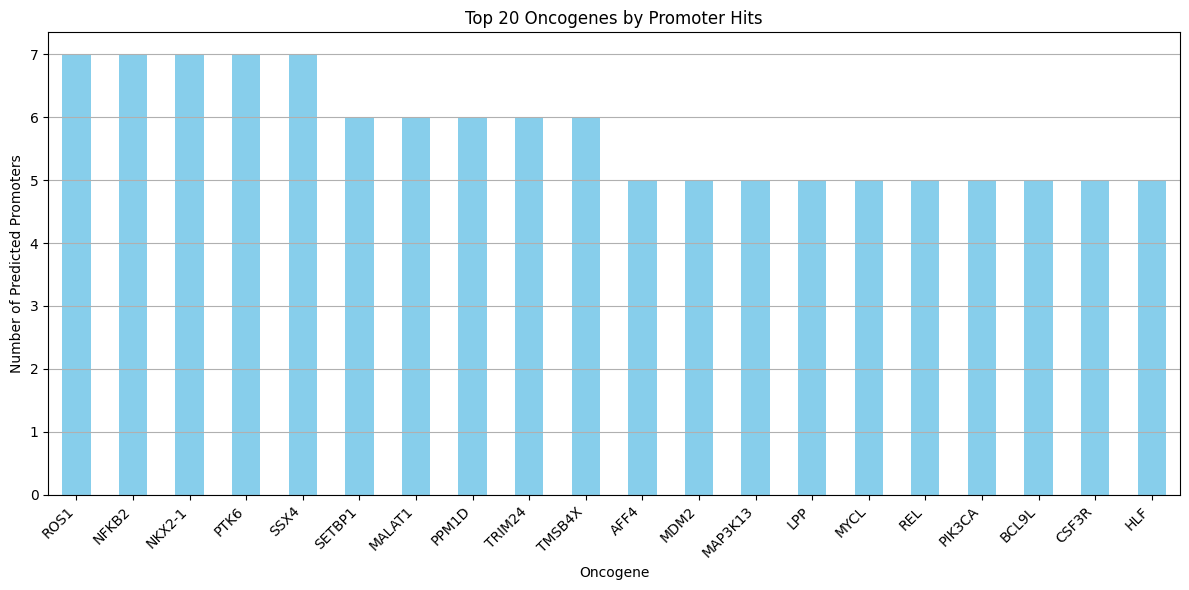

In [ ]:
import matplotlib.pyplot as plt

# Count hits per gene
gene_counts = df_results['gene'].value_counts().head(20)  # top 20

# Plot
plt.figure(figsize=(12, 6))
gene_counts.plot(kind='bar', color='skyblue')
plt.title("Top 20 Oncogenes by Promoter Hits")
plt.ylabel("Number of Predicted Promoters")
plt.xlabel("Oncogene")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


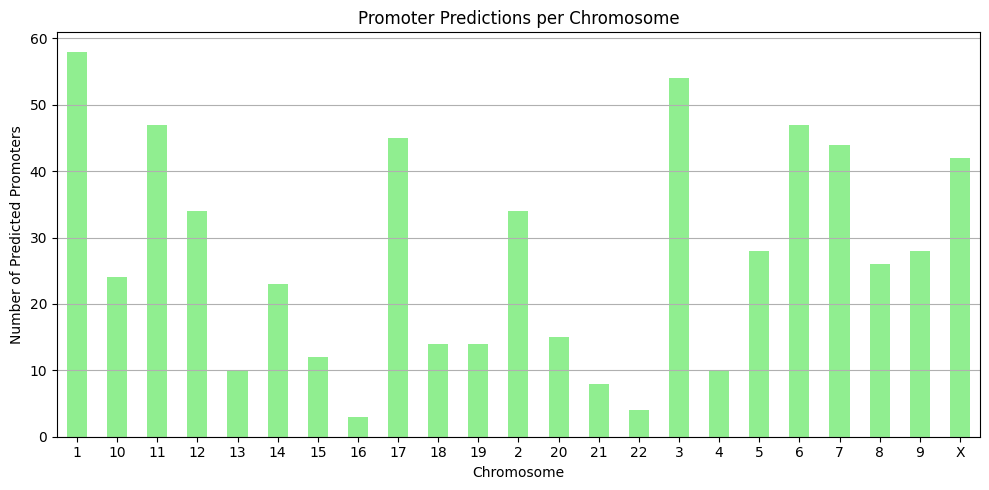

In [ ]:
# Normalize chromosome names (optional)
df_results['chr'] = df_results['chr'].astype(str)

# Count hits per chromosome
chr_counts = df_results['chr'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
chr_counts.plot(kind='bar', color='lightgreen')
plt.title("Promoter Predictions per Chromosome")
plt.ylabel("Number of Predicted Promoters")
plt.xlabel("Chromosome")
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


# Simulation of CRISPR Silencing

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq

# Load genome once
genome = {
    record.id.replace("chr", "").replace("CHR", ""): record.seq.upper()
    for record in SeqIO.parse("/content/drive/MyDrive/Homo_sapiens.GRCh38.dna.primary_assembly.fa", "fasta")
}

def simulate_crispr_silencing_with_real_dna(results, genome):
    simulations = []

    for promoter in results:
        chrom = promoter['chr'].replace("chr", "").replace("CHR", "")
        gene = promoter['gene']
        strand = promoter['strand']
        start = promoter['promoter_start']
        end = promoter['promoter_end']
        prob = promoter['probability']

        if chrom not in genome:
            continue

        # Random CRISPR cut site within promoter
        gRNA_start = random.randint(start, end - 21)
        gRNA_end = gRNA_start + 20
        seq = genome[chrom][gRNA_start:gRNA_end]

        if strand == '-':
            seq = seq.reverse_complement()

        simulations.append({
            "gene": gene,
            "chr": chrom,
            "strand": strand,
            "gRNA_target_start": gRNA_start,
            "gRNA_target_end": gRNA_end,
            "gRNA_sequence": str(seq),
            "promoter_probability": prob,
            "simulated_effect": f"Silencing {gene} by targeting predicted promoter"
        })

    return simulations


In [ ]:
crispr_real = simulate_crispr_silencing_with_real_dna(results, genome)
pd.DataFrame(crispr_real).head()


,gene,chr,strand,gRNA_target_start,gRNA_target_end,gRNA_sequence,promoter_probability,simulated_effect
0,A1CF,10,+,50799076,50799096,CTGGAGGAATAGTTTGCTCT,0.623757,Silencing A1CF by targeting predicted promoter
1,A1CF,10,+,50799132,50799152,TTGATTTCAGGGCCCACTTA,0.745021,Silencing A1CF by targeting predicted promoter
2,ABL2,1,+,179098750,179098770,GCTTCATGTTGAAGACACAC,0.819182,Silencing ABL2 by targeting predicted promoter
3,ABL2,1,+,179098944,179098964,AGGCAGAGGTGGGTGGATCA,0.623179,Silencing ABL2 by targeting predicted promoter
4,ACKR3,2,+,236567571,236567591,GTTTTCTGGGACAGGGTGGG,0.782760,Silencing ACKR3 by targeting predicted promoter


# Saving CRISPR simulation results in csv

In [ ]:
import pandas as pd

# Convert the list of CRISPR simulations to a DataFrame
df_crispr = pd.DataFrame(crispr_real)

# Define path to save in your Google Drive
output_path = "/content/drive/MyDrive/promoter_crispr_simulation.csv"

# Save to CSV
df_crispr.to_csv(output_path, index=False)

print(f"✅ CRISPR simulation results saved to:\n{output_path}")


✅ CRISPR simulation results saved to:
/content/drive/MyDrive/promoter_crispr_simulation.csv


# Another CRISPR Silencing function with overexpression condition depending on the simulated expression csv

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.2 MB/s eta 0:00:00


In [ ]:
expression_df.head()

,Gene,Expression_Cancer,Expression_Normal,Overexpressed
0,TP53,59.93,23.24,YES
1,EGFR,47.23,16.15,YES
2,BRCA1,62.95,13.23,YES
3,BRCA2,80.46,26.12,YES
4,KRAS,45.32,30.31,NO


In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import random
import pandas as pd

# Load genome once
genome = {
    record.id.replace("chr", "").replace("CHR", ""): record.seq.upper()
    for record in SeqIO.parse("/content/drive/MyDrive/Homo_sapiens.GRCh38.dna.primary_assembly.fa", "fasta")
}

# Load gene expression data
expression_df = pd.read_csv("/content/drive/MyDrive/large_simulated_gene_expression.csv")

def simulate_crispr_silencing_Overexpressed(results, genome, expression_df):
    simulations = []

    for promoter in results:
        chrom = promoter['chr'].replace("chr", "").replace("CHR", "")
        gene = promoter['gene']
        strand = promoter['strand']
        start = promoter['promoter_start']
        end = promoter['promoter_end']
        prob = promoter['probability']

        # Check if gene is overexpressed
        exp_row = expression_df[expression_df['Gene'] == gene]
        if exp_row.empty or exp_row['Overexpressed'].values[0] != "YES":
            continue  # Skip this gene if not overexpressed

        if chrom not in genome:
            continue

        # Random CRISPR cut site within promoter
        gRNA_start = random.randint(start, end - 21)
        gRNA_end = gRNA_start + 20
        seq = genome[chrom][gRNA_start:gRNA_end]

        if strand == '-':
            seq = seq.reverse_complement()

        simulations.append({
            "gene": gene,
            "chr": chrom,
            "strand": strand,
            "gRNA_target_start": gRNA_start,
            "gRNA_target_end": gRNA_end,
            "gRNA_sequence": str(seq),
            "promoter_probability": prob,
            "simulated_effect": f"Silencing {gene} by targeting predicted promoter"
        })

    return simulations


In [ ]:
crispr_real_Overexpressed = simulate_crispr_silencing_Overexpressed(results, genome, expression_df)
pd.DataFrame(crispr_real_Overexpressed).head()


,gene,chr,strand,gRNA_target_start,gRNA_target_end,gRNA_sequence,promoter_probability,simulated_effect
0,AR,X,+,67543261,67543281,CAAAGCAAACGTTTACAGAG,0.718869,Silencing AR by targeting predicted promoter
1,AR,X,+,67543565,67543585,CCTCAGTTTGTAGGAGACTC,0.505562,Silencing AR by targeting predicted promoter
2,CDK4,12,+,57746949,57746969,TCGGCATAGGTATTAGTCAC,0.668768,Silencing CDK4 by targeting predicted promoter
3,CDK4,12,+,57747046,57747066,GATGTGTGGAGAAAAGTTTC,0.690286,Silencing CDK4 by targeting predicted promoter
4,CDK4,12,+,57747399,57747419,CTTGTCACATCCTCTAAAAT,0.533227,Silencing CDK4 by targeting predicted promoter


# Saving OverExpressed Silencing Outputs

In [ ]:
import pandas as pd

# Convert the list of CRISPR simulations to a DataFrame
df_crispr_overexpressed = pd.DataFrame(crispr_real_Overexpressed)

# Define path to save in your Google Drive
output_path = "/content/drive/MyDrive/promoter_crispr_simulation_Overexpressed.csv"

# Save to CSV
df_crispr_overexpressed.to_csv(output_path, index=False)

print(f"✅ CRISPR simulation results saved to:\n{output_path}")


✅ CRISPR simulation results saved to:
/content/drive/MyDrive/promoter_crispr_simulation_Overexpressed.csv


# Trial for Using Real Datasets for CRISPR Silencing Only Overexpressed Oncogenes but unavailable Rams

In [ ]:
import pandas as pd

# Path to your file (update if needed)
expr_path = "/content/drive/MyDrive/TcgaTargetGtex_rsem_gene_tpm.gz"

# Load gene expression data
df_expr = pd.read_csv(expr_path, sep='\t', index_col=0)
print("Expression matrix shape:", df_expr.shape)
df_expr.head()


# Another Model Trials

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

model = Sequential([
    Conv1D(16, kernel_size=10, activation='relu', input_shape=(301, 4)),
    MaxPooling1D(2),
    Conv1D(32, kernel_size=5, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 292, 16)        │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 146, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 142, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 71, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       145,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,785 (581.19 KB)

 Trainable params: 148,785 (581.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.2, callbacks=[early_stop])



Epoch 1/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9350 - loss: 0.2317 - val_accuracy: 0.8662 - val_loss: 0.4197
Epoch 2/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9387 - loss: 0.2256 - val_accuracy: 0.8617 - val_loss: 0.4492
Epoch 3/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9380 - loss: 0.2252 - val_accuracy: 0.8662 - val_loss: 0.4747
Epoch 4/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9384 - loss: 0.2251 - val_accuracy: 0.8631 - val_loss: 0.4620
